## The data block API
The data block API lets you customize the creation of a DataBunch by isolating the underlying parts of that process in separate blocks, mainly:

Where are the inputs and how to create them?
How to split the data into a training and validation sets?
How to label the inputs?
What transforms to apply?
How to add a test set?
How to wrap in dataloaders and create the DataBunch?
Each of these may be addressed with a specific block designed for your unique setup. Your inputs might be in a folder, a csv file, or a dataframe. You may want to split them randomly, by certain indices or depending on the folder they are in. You can have your labels in your csv file or your dataframe, but it may come from folders or a specific function of the input. You may choose to add data augmentation or not. A test set is optional too. Finally you have to set the arguments to put the data together in a DataBunch (batch size, collate function...)

The data block API is called as such because you can mix and match each one of those blocks with the others, allowing for a total flexibility to create your customized DataBunch for training, validation and testing. The factory methods of the various DataBunch are great for beginners but you can't always make your data fit in the tracks they require.

Mix and match

As usual, we'll begin with end-to-end examples, then switch to the details of each of those parts.

### Examples of use
Let's begin with our traditional MNIST example.

In [1]:
from fastai.vision import *

In [2]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)
path.ls()

[WindowsPath('C:/Users/Tim/.fastai/data/mnist_tiny/labels.csv'),
 WindowsPath('C:/Users/Tim/.fastai/data/mnist_tiny/models'),
 WindowsPath('C:/Users/Tim/.fastai/data/mnist_tiny/test'),
 WindowsPath('C:/Users/Tim/.fastai/data/mnist_tiny/train'),
 WindowsPath('C:/Users/Tim/.fastai/data/mnist_tiny/valid')]

In [3]:
(path/'train').ls()

[WindowsPath('C:/Users/Tim/.fastai/data/mnist_tiny/train/3'),
 WindowsPath('C:/Users/Tim/.fastai/data/mnist_tiny/train/7')]

In [4]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64)

This is a shortcut method which is aimed at data that is in folders following an ImageNet style, with the train and valid directories, each containing one subdirectory per class, where all the labelled pictures are. There is also a test directory containing unlabelled pictures.

Here is the same code, but this time using the data block API, which can work with any style of a dataset. All the stages, which will be explained below, can be grouped together like this:

In [5]:
data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

In [8]:
data.train_ds[0]

(Image (3, 64, 64), Category 3)

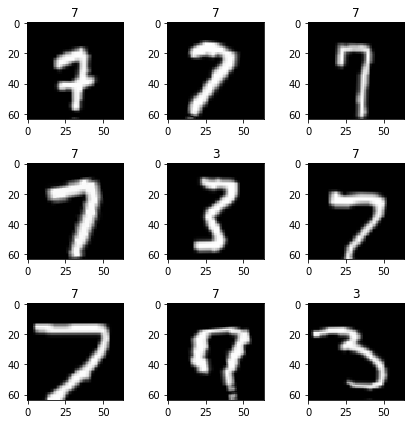

In [6]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [9]:
data.valid_ds.classes

['3', '7']

## Another Example 
Let's look at another example from vision.data with the planet dataset. This time, it's a multiclassification problem with the labels in a csv file and no given split between valid and train data, so we use a random split. The factory method is:

In [10]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [11]:
pd.read_csv(planet/"labels.csv").head()

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


In [12]:
data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', label_delim = ' ', ds_tfms=planet_tfms)

In [13]:
planet.ls()

[WindowsPath('C:/Users/Tim/.fastai/data/planet_tiny/labels.csv'),
 WindowsPath('C:/Users/Tim/.fastai/data/planet_tiny/train')]

In [14]:
pd.read_csv(planet/"labels.csv").head()

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


In [15]:
data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(label_delim=' ')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(planet_tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())                          
        #Finally -> use the defaults for conversion to databunch

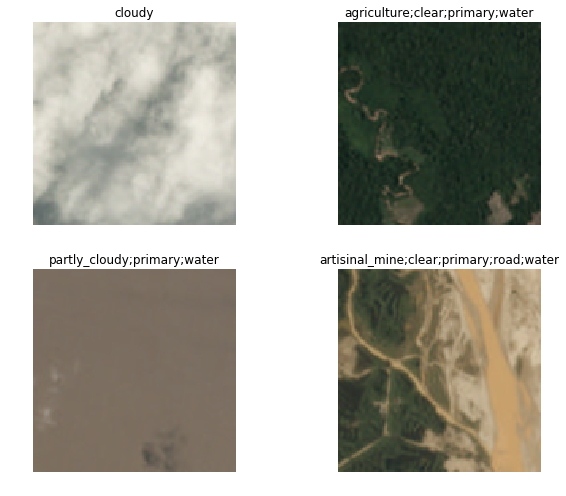

In [16]:
data.show_batch(rows=2, figsize=(9,7))

## Create databunch from raw data
The data block API also allows you to get your data together in problems for which there is no direct ImageDataBunch factory method. For a segmentation task, for instance, we can use it to quickly get a DataBunch. Let's take the example of the camvid dataset. The images are in an 'images' folder and their corresponding mask is in a 'labels' folder.

In [3]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We have a file that gives us the names of the classes (what each code inside the masks corresponds to: a pedestrian, a tree, a road...)

In [4]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

And we define the following function that infers the mask filename from the image filename.

In [5]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Then we can easily define a DataBunch using the data block API. Here we need to use tfm_y=True in the transform call because we need the same transforms to be applied to the target mask as were applied to the image. Side note: For further control over which transformations are used on the target, each transformation has a use_on_y parameter

In [6]:
vdata = (SegmentationItemList.from_folder(path_img)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=128)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch())
        #Finally -> use the defaults for conversion to databunch

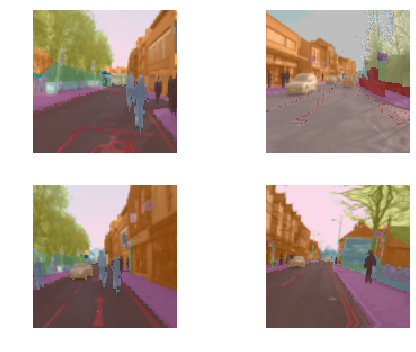

In [7]:
vdata.show_batch(rows=2, figsize=(7,5))

Another example for object detection. We use our tiny sample of the COCO dataset here. http://files.fast.ai/data/examples/coco_tiny There is a helper function in the library that reads the annotation file and returns the list of images names with the list of labelled bboxes associated to it. We convert it to a dictionary that maps image names with their bboxes and then write the function that will give us the target for each image filename.

In [2]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

The following code is very similar to what we saw before. The only new addition is the use of a special function to collate the samples in batches. This comes from the fact that our images may have multiple bounding boxes, so we need to pad them to the largest number of bounding boxes.

In [3]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch, use a batch size of 16,
        # and we use bb_pad_collate to collate the data into a mini-batch

d:\soft\anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


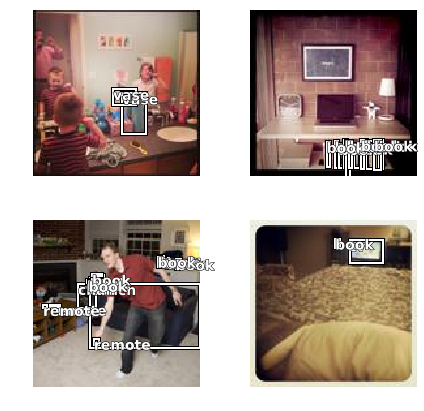

In [4]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(6,6))

## Text data
But vision isn't the only application where the data block API works. It can also be used for text and tabular data. With our sample of the IMDB dataset (labelled texts in a csv file), here is how to get the data together for a language model.

In [5]:
from fastai.text import *

In [6]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [7]:
data_lm = (TextList
           .from_csv(imdb, 'texts.csv', cols='text')
           #Where are the text? Column 'text' of texts.csv
           .split_by_rand_pct()
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch())
           #Finally we convert to a DataBunch

In [8]:
data_lm.show_batch()

idx,text
0,"! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a xxunk of xxmaj jonestown - hollywood style . xxmaj xxunk ! xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is"
1,"and his sister . xxbos xxmaj father and son xxunk very little . xxup in fact they speak different xxunk . but when the son drives his father xxunk miles for his xxunk 's to xxmaj xxunk , the conversations finally take place . they are difficult and xxunk is necessary on both parts . \n \n xxmaj this movie takes us into the hearts of these two xxunk"
2,"that is xxunk from the very start . xxmaj while the ever present rain xxunk my xxunk of a misplaced story ( even if claiming to be set in xxmaj california the movie was largely shot around a stormy xxmaj xxunk , xxup xxunk ) , the dark and oppressive xxunk beautifully xxunk xxmaj xxunk ' excellent acting . xxbos this is just usual xxmaj indian garbage that gets turned"
3,"hence the title ) . xxmaj the film basically just plods along for xxunk five minutes and there really are n't many scenes of interest . xxmaj it 's a real shame that xxmaj xxunk xxmaj franco ended up making films like this because the man clearly has talent ; as seen by films such as xxmaj the xxmaj diabolical xxmaj xxunk z , xxmaj xxunk in xxmaj furs ,"
4,"a few seconds of screen time . xxmaj the same with xxmaj xxunk . i did like xxmaj xxunk xxmaj march 's interpretation of xxmaj valjean a lot , however , which was one of the redeeming features of the movie . xxmaj on the other hand , xxmaj charles xxmaj xxunk , for all his great acting in other movies , seems to have missed the mark with xxmaj"
